# Reweighing ~ Race

In [1]:
#import libraries and filter warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2024-09-09 00:46:29.427816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/elton/anaconda3/envs/Dissertation/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
# Load the data
train = pd.read_csv(r'../Resources/Data/baseline_train_data.csv')
test = pd.read_csv(r'../Resources/Data/baseline_test_data.csv')
valid = pd.read_csv(r'../Resources/Data/baseline_valis_data.csv')

target = 'two_year_recid'

# Separate features and target for training, testing, and validation data
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

X_valid = valid.drop(columns=[target])
y_valid = valid[target]

In [3]:
# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

In [4]:
# Convert training data to AIF360 BinaryLabelDataset format
train_aif = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                               label_names=[target],
                               protected_attribute_names=['race'])

# Apply reweigher
reweigher = Reweighing(unprivileged_groups=unprivileged_groups,
                       privileged_groups=privileged_groups)
train_aif_rw = reweigher.fit_transform(train_aif)

In [5]:
# Fit the logistic regression model with sample weights
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_aif_rw.features, train_aif_rw.labels.ravel(), sample_weight=train_aif_rw.instance_weights)

y_pred_test = log_reg.predict(X_test)

Test Accuracy: 0.6300505050505051


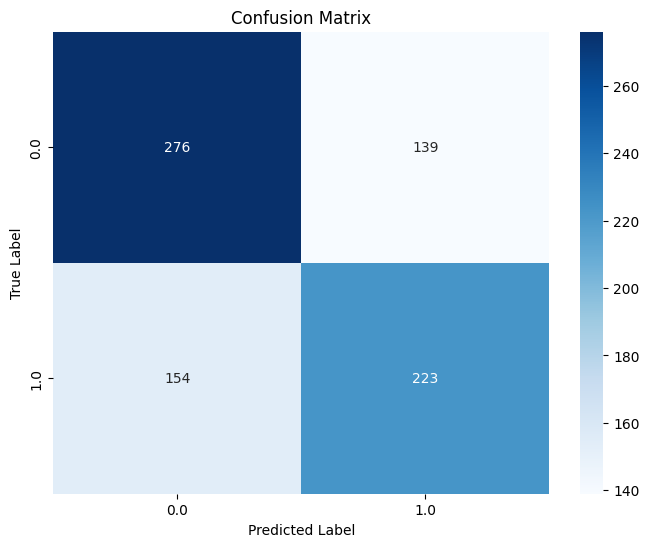

In [6]:
print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test)}')

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# Combine predicted labels with the test features
test_with_pred = X_test.copy()
test_with_pred[target] = y_test
test_with_pred['y_pred'] = y_pred_test

# Convert to AIF360 BinaryLabelDataset format
test_aif = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                              label_names=[target],
                              protected_attribute_names=['race'])

test_aif_pred = BinaryLabelDataset(df=pd.concat([X_test, pd.Series(y_pred_test, name=target)], axis=1),
                                   label_names=[target],
                                   protected_attribute_names=['race'])

In [8]:
# Compute fairness metrics
metric_test_pred = ClassificationMetric(test_aif, test_aif_pred,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)

stat_parity_diff = metric_test_pred.statistical_parity_difference()
avg_odds_diff = metric_test_pred.average_odds_difference()
equal_opp_diff = metric_test_pred.equal_opportunity_difference()

print(f"Statistical Parity Difference: {stat_parity_diff}")
print(f"Average Odds Difference: {avg_odds_diff}")
print(f"Equal Opportunity Difference: {equal_opp_diff}")

Statistical Parity Difference: 0.06696172444881565
Average Odds Difference: 0.02655016016802153
Equal Opportunity Difference: 0.09857397504456322
